In [1]:
# set up things
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
# load necessary libraries
# you should install cartopy with 'conda install -c conda-forge cartopy'
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import math

import matplotlib as mpl  
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import sys
print(sys.path)
sys.path.insert(0, "/home/x711/code/nmc_met_io") # .append("/home/x711/code/nmc_met_io")
print(sys.path)
from nmc_met_io.retrieve_cassandraDB  import *


xr.set_options(display_style="text")

['/home/x711/code/weather-plot', '/home/x711/anaconda3/lib/python39.zip', '/home/x711/anaconda3/lib/python3.9', '/home/x711/anaconda3/lib/python3.9/lib-dynload', '', '/home/x711/anaconda3/lib/python3.9/site-packages']
['/home/x711/code/nmc_met_io', '/home/x711/code/weather-plot', '/home/x711/anaconda3/lib/python39.zip', '/home/x711/anaconda3/lib/python3.9', '/home/x711/anaconda3/lib/python3.9/lib-dynload', '', '/home/x711/anaconda3/lib/python3.9/site-packages']


## 1.1 读取多个时次的模式预报数据 Rain

In [41]:
%time
"""
ECMWF_HR/RAIN12/22062808.012
GERMAN_HR/RAIN12/22062808.012
NCEP_GFS_HR/RAIN12/22062808.012
JAPAN_HR/RAIN12/22062808.012
GRAPES_GFS/RAIN12/22062808.015

GRAPES_3KM/RAIN12/22062811.012
SHANGHAI_MR/RAIN12/22062808.012
BEIJING_MR/RAIN12/22062808.012
"""
directoryRAIN12 = "ECMWF_HR/RAIN12"
directorySeaLevel = "ECMWF_HR/PRMSL"
fhours = np.arange(24, 96, 12)
filenames = ['22082408.'+'%03d'%(fhour) for fhour in fhours]
Rain12 = get_model_grids(directoryRAIN12, filenames, varname='Rain', varattrs={'long_name':'12 hours rain', 'units':'mm'}, cache=False)
HSeaLevel = get_model_grids(directorySeaLevel, filenames, varname='PRMSL', varattrs={'long_name':'Sea Level Pressure', 'units':'hPa'}, cache=False)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


/home/x711/code/nmc_met_io/nmc_met_io/retrieve_cassandraDB.py:474: UserWarning: ECMWF_HR/RAIN12/22082408.036 doese not exists.
  warnings.warn("{} doese not exists.".format(directory+'/'+filename))
/home/x711/code/nmc_met_io/nmc_met_io/retrieve_cassandraDB.py:474: UserWarning: ECMWF_HR/PRMSL/22082408.036 doese not exists.
  warnings.warn("{} doese not exists.".format(directory+'/'+filename))


In [43]:
Rain12

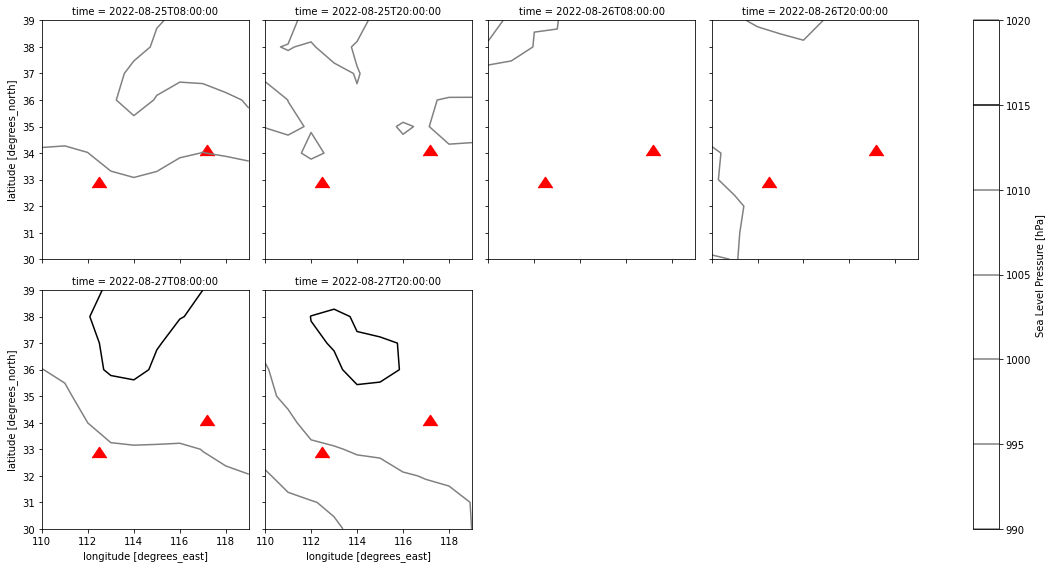

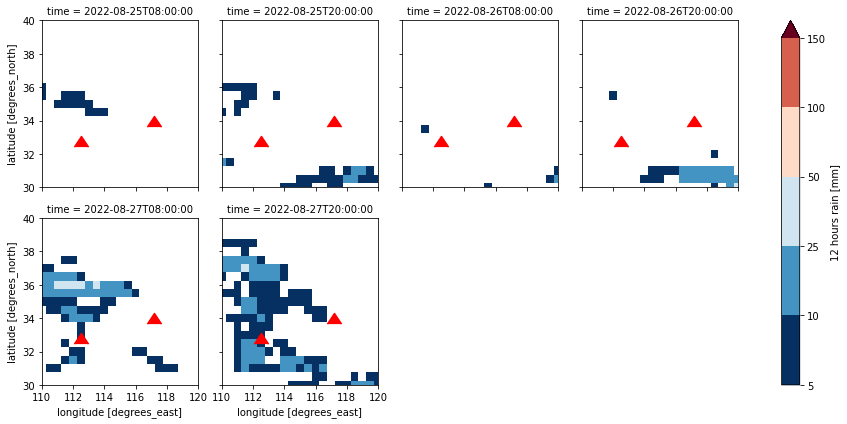

In [40]:
# 绘制图像
left = 110
right=120
top = 40
bottom = 30

marker_lon, marker_lat = [112.485, 117.163], [33.1, 34.295] #118.5, 28.7 #112, 34.5

lon=np.arange(left,right,1)
lat=np.arange(bottom,top,1)

Rain12Area = Rain12.Rain.sel(lon=np.arange(left,right,0.125),lat=np.arange(bottom,top,0.125), method="nearest")
HSeaLevelArea = HSeaLevel.PRMSL.sel(lon=lon,lat=lat, method="nearest")

HSeaLevelcolors = ['gray']*10
HSeaLevelcolors[-3] = HSeaLevelcolors[-5] = 'black'

p = HSeaLevelArea.plot.contour(figsize=(16, 8), col='time', col_wrap=4, levels=np.arange(990,1025,5), colors = HSeaLevelcolors, add_colorbar=True) #[24, 28]

for ax in p.axes.flat:
    ax.scatter(marker_lon, marker_lat, s=200, c='red', marker=6)


rain_levels = [5, 10, 25, 50, 100, 150]
p = Rain12Area.plot(col='time', col_wrap=4, levels=rain_levels, extend='max', add_colorbar=True)

for ax in p.axes.flat:
    ax.scatter(marker_lon, marker_lat, s=200, c='red', marker=6)

In [6]:
s1 = xr.Dataset(data_vars={
    'a1': (['x1','y1'],[[1,2,3],[5,6,7]]),
    'a2':(['x1','y2'],[[1,2,3,4],[5,6,7,8]])
})

s2 = xr.Dataset(data_vars={
    'a1': (['x1','y1'],[[11,12,13],[15,16,17]]),
    'a2':(['x1','y2'],[[21,22,23,24],[25,26,27,28]])
})

s12 = xr.merge([s1,s2], compat='override')

s12.isel(x1=1)

<xarray.Dataset>
Dimensions:  (y1: 3, y2: 4)
Dimensions without coordinates: y1, y2
Data variables:
    a1       (y1) int64 5 6 7
    a2       (y2) int64 5 6 7 8

In [7]:
def get_models_grid(directorys, filename, varnames = None, allExists=False, pbar=False, **kargs):
    """
    Retrieve multiple time grids from MICAPS cassandra service.
    
    Args:
        directorys (string): the data directorys on the service.
        filename (list): the filename.
        allExists (boolean): all files should exist, or return None.
        pbar (boolean): Show progress bar, default to False.
        **kargs: key arguments passed to get_model_grid function.

    Examples:
        models = ["ECMWF_HR", "GERMAN_HR", "NCEP_GFS_HR", "JAPAN_HR", "GRAPES_GFS", "GRAPES_3KM", "SHANGHAI_MR", "BEIJING_MR"]
        directorys = [model + "/RAIN12" for model in models]
        print(directorys)

        models_grid = get_models_grid(directorys, '22062420.048', cache=False)
    """

    dataset = []
    if pbar:
        tqdm_directorys = tqdm(directorys, desc=filename + ": ")
    else:
        tqdm_directorys = directorys

    if varnames is None:
        varnames = []
        for dir in directorys:
            'a/b/c'.replace('/', '_')
            varnames.append(dir.replace('/', '_'))
    
    size = len(tqdm_directorys)

    for index in range(0, size):
        directory = tqdm_directorys[index]
        data = get_model_grid(directory, filename, varname='data', **kargs)
        if data:
            #print(data)
            data.attrs["name"] = varnames[index]
            #print(data)

            dataset.append(data)
        else:
            warnings.warn("{} doese not exists.".format(directory+'/'+filename))
            if allExists:    
                return None
    
    return dataset #xr.merge(dataset)


In [20]:
""" 
ECMWF_HR/RAIN12/22062808.012
GERMAN_HR/RAIN12/22062808.012
NCEP_GFS_HR/RAIN12/22062808.012
JAPAN_HR/RAIN12/22062808.012
GRAPES_GFS/RAIN12/22062808.015

GRAPES_3KM/RAIN12/22062811.012
SHANGHAI_MR/RAIN12/22062808.012
BEIJING_MR/RAIN12/22062808.012 """

models = ["ECMWF_HR", "GERMAN_HR", "NCEP_GFS_HR", "JAPAN_HR", "GRAPES_GFS", "GRAPES_3KM", "SHANGHAI_MR", "BEIJING_MR"]
directorys = [model + "/RAIN12" for model in models]
print(directorys)

['ECMWF_HR/RAIN12', 'GERMAN_HR/RAIN12', 'NCEP_GFS_HR/RAIN12', 'JAPAN_HR/RAIN12', 'GRAPES_GFS/RAIN12', 'GRAPES_3KM/RAIN12', 'SHANGHAI_MR/RAIN12', 'BEIJING_MR/RAIN12']


In [9]:
def plot_models_grid(models_grid, figsize = (20,10), cols = 4, **kargs):

    fig = plt.figure(figsize=figsize)
    index = 0

    total_col = cols
    total_row = math.ceil(len(models_grid)/total_col)
    for model_grid in models_grid:
        ax = fig.add_subplot(total_row,total_col, index+1)

        RainArea = model_grid.data.isel(time=0).sel(lon=np.arange(left,right,0.125),lat=np.arange(bottom,top,0.125), method="nearest")
        RainArea.plot(ax=ax, levels=rain_levels,colors=['#ccc','green','blue','red','#000'], extend='max', **kargs)

        title = model_grid.attrs["name"]
        ax.set_title(title)
        ax.scatter(marker_lon, marker_lat, s=200, c='red', marker=6)

        index = index + 1

    return fig

/tmp/ipykernel_3249/1229242446.py:44: UserWarning: NCEP_GFS_HR/RAIN12/22072420.024 doese not exists.
  warnings.warn("{} doese not exists.".format(directory+'/'+filename))
/tmp/ipykernel_3249/1229242446.py:44: UserWarning: GRAPES_3KM/RAIN12/22072420.024 doese not exists.
  warnings.warn("{} doese not exists.".format(directory+'/'+filename))
/tmp/ipykernel_3249/1229242446.py:44: UserWarning: BEIJING_MR/RAIN12/22072420.024 doese not exists.
  warnings.warn("{} doese not exists.".format(directory+'/'+filename))


'no return'

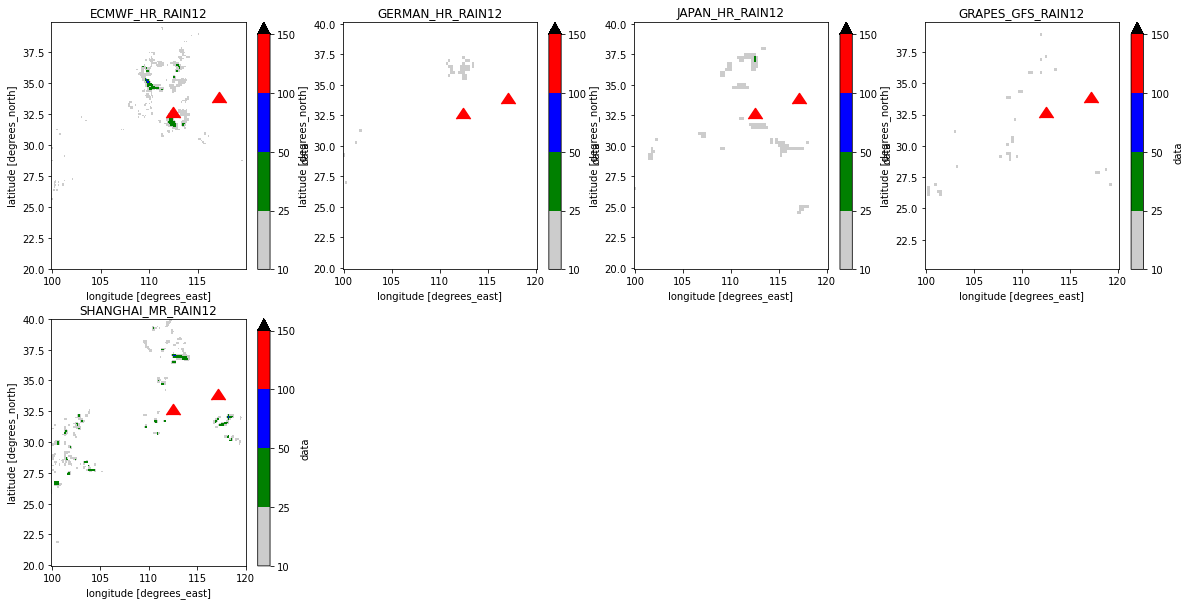

In [23]:
models_grid = get_models_grid(directorys, '22072420.024', cache=False)
plot_models_grid(models_grid)

'no return'

## 1.2 Draw Surface Plot

In [11]:
""" 
SURFACE/PLOT_GLOBAL_1H
SURFACE/PLOT_GLOBAL_3H
mdfs:///SURFACE/PLOT_GLOBAL_ALL_1H/20220625130000.000
mdfs:///SURFACE/PLOT_GLOBAL_ALL_3H/20220625130000.000 
mdfs:///SURFACE/PLOT_NATIONAL_1H/20220625130000.000
mdfs:///SURFACE/PLOT_NATIONAL/20220625130000.000

mdfs:///SURFACE/RAIN12_NATIONAL/20220626200000.000
mdfs:///SURFACE/RAIN12_GLOBAL_STATION/20220626200000.000
mdfs:///SURFACE/RAIN01_ALL_STATION/20220628150000.000

mdfs:///SURFACE/RAIN12_ALL_STATION/20220626200000.000

"""
plotSurface = get_station_data("SURFACE/RAIN12_ALL_STATION", "20220626200000.000", dropna=True, cache=False)
plotSurface

,ID,lon,lat,Rain_12h,1010,Alt,Grade,time
0,774153,119.459999,34.279999,1.600,False,4.500000,16.0,2022-06-26 20:00:00
1,774152,119.330002,34.430000,3.500,False,2.000000,16.0,2022-06-26 20:00:00
2,774151,119.209999,34.299999,3.200,False,3.000000,14.0,2022-06-26 20:00:00
3,688135,115.989998,35.200001,4.100,False,32.599998,16.0,2022-06-26 20:00:00
4,860205,108.139999,35.119999,11.800,False,1218.000000,14.0,2022-06-26 20:00:00
...,...,...,...,...,...,...,...,...
2225,57328,107.510002,31.209999,10.300,False,344.899994,12.0,2022-06-26 20:00:00
2226,57329,107.849998,31.100000,9.400,False,468.700012,13.0,2022-06-26 20:00:00
2227,57333,108.660004,31.940001,0.001,True,792.799988,13.0,2022-06-26 20:00:00
2228,864251,109.900002,34.020000,5.700,False,838.000000,14.0,2022-06-26 20:00:00


In [12]:
plotSurface[0:1].to_json()

'{"ID":{"0":774153},"lon":{"0":119.4599990845},"lat":{"0":34.2799987793},"Rain_12h":{"0":1.6000000238},"1010":{"0":false},"Alt":{"0":4.5},"Grade":{"0":16.0},"time":{"0":1656273600000}}'

In [13]:
plotRain12 = plotSurface[['ID', 'lon', 'lat', 'Rain_12h']]

In [14]:
SLP = plotRain12.dropna(how='all') #how='any'
SLP = SLP[(bottom <= SLP['lat']) & (SLP['lat'] <= top) &
            (left <= SLP['lon']) & (SLP['lon'] <= right)]

plotRain12

,ID,lon,lat,Rain_12h
0,774153,119.459999,34.279999,1.600
1,774152,119.330002,34.430000,3.500
2,774151,119.209999,34.299999,3.200
3,688135,115.989998,35.200001,4.100
4,860205,108.139999,35.119999,11.800
...,...,...,...,...
2225,57328,107.510002,31.209999,10.300
2226,57329,107.849998,31.100000,9.400
2227,57333,108.660004,31.940001,0.001
2228,864251,109.900002,34.020000,5.700


In [15]:
def getRain12Color(v):
    colors = ['#fff0','#ccc','green','blue','red','#000']
    index = 0
    for l in rain_levels:
        if v < l:
            return colors[index]
        
        index = index + 1

    return '#000'


SLP['color'] = SLP['Rain_12h'].apply(getRain12Color)
#mpl.colors.ListedColormap(SLP['color'].to_list())

### Contour plot of irregularly spaced data
https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html#sphx-glr-gallery-images-contours-and-fields-irregulardatagrid-py

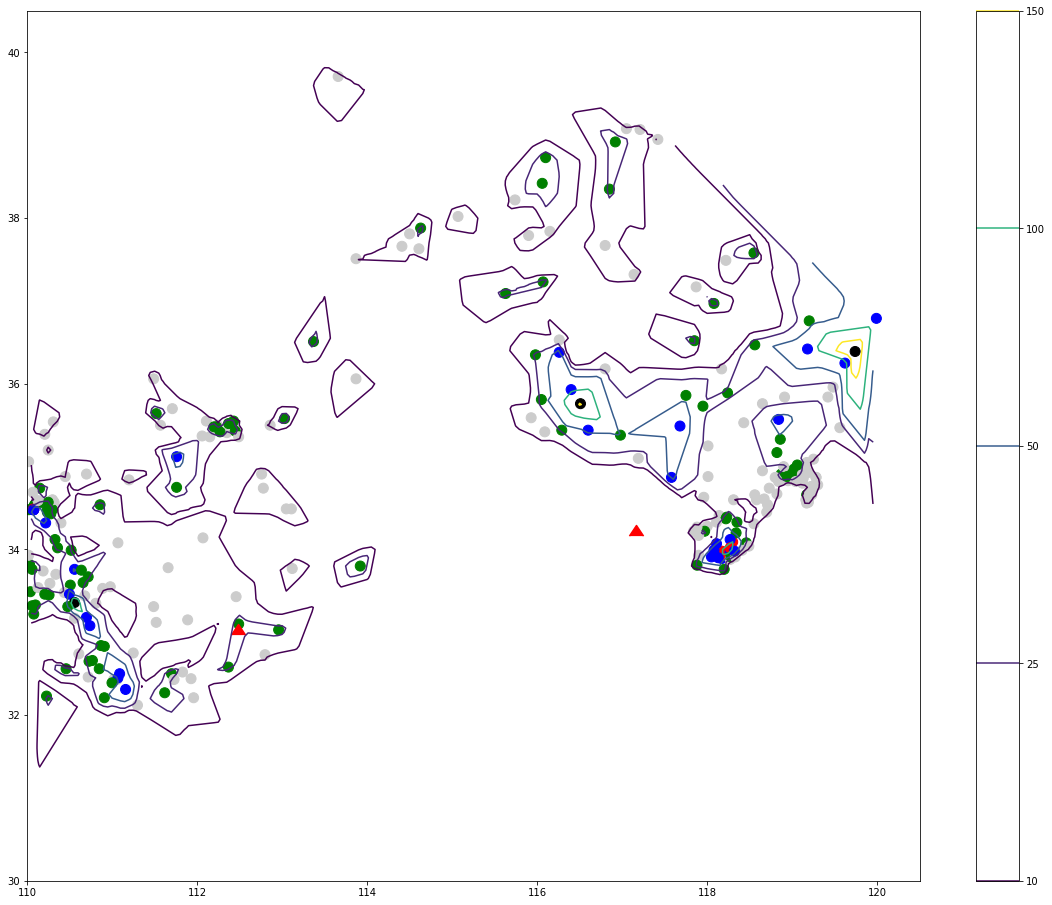

In [16]:
# plot:
fig, ax = plt.subplots(figsize=(20, 16))

#ax.plot(SLP.lon, SLP.lat, 'o', markersize=2, color='gray')
ax.scatter(SLP.lon, SLP.lat, s=100, c = SLP.color, marker='o')
#cntr = ax.tricontour(SLP.lon, SLP.lat, SLP.Rain_12h, levels=rain_levels, colors = 'blue')

#Interpolate the data to a regular grid first.
lon=np.arange(left,right,0.05)
lat=np.arange(bottom,top,0.05)

SLP_Grid = griddata((SLP.lon, SLP.lat), SLP.Rain_12h, (lon[None, :], lat[:, None]), method='linear')
cntr = ax.contour(lon, lat, SLP_Grid, levels=rain_levels) #add_colorbar=True //, colors = 'red'

ax.scatter(marker_lon, marker_lat, s=200, c='red', marker=6)
fig.colorbar(cntr, ax=ax)

## 1.3 Draw Rain Diff

In [17]:
left = 100
right=120
top = 40
bottom = 20

directorys = [model + "/RAIN06" for model in models]
models_grid2 = get_models_grid(directorys, '22062908.012', cache=False)

fig = plot_models_grid(models_grid2, figsize=(20,30), cols=2, alpha=0.6)

plotSurface = get_station_data("SURFACE/RAIN06_ALL_STATION", "20220629140000.000", dropna=True, cache=False)
print(plotSurface[0:1].to_json())

col_rain_name = 'Rain_6h'
plotRain03 = plotSurface[['ID', 'lon', 'lat', col_rain_name]]

SLP = plotRain03.dropna(how='any')
SLP = SLP[(bottom <= SLP['lat']) & (SLP['lat'] <= top) &
            (left <= SLP['lon']) & (SLP['lon'] <= right)]

#sort so that plot large rain later
SLP.sort_values(by=[col_rain_name], inplace=True)

SLP['color'] = SLP[col_rain_name].apply(getRain12Color)

for ax in fig.axes:
    ax.scatter(SLP.lon, SLP.lat, s=40, c = SLP.color, marker='o')
    pass

/tmp/ipykernel_3249/1229242446.py:44: UserWarning: ECMWF_HR/RAIN06/22062908.012 doese not exists.
  warnings.warn("{} doese not exists.".format(directory+'/'+filename))
/tmp/ipykernel_3249/1229242446.py:44: UserWarning: GERMAN_HR/RAIN06/22062908.012 doese not exists.
  warnings.warn("{} doese not exists.".format(directory+'/'+filename))
/tmp/ipykernel_3249/1229242446.py:44: UserWarning: NCEP_GFS_HR/RAIN06/22062908.012 doese not exists.
  warnings.warn("{} doese not exists.".format(directory+'/'+filename))
/tmp/ipykernel_3249/1229242446.py:44: UserWarning: JAPAN_HR/RAIN06/22062908.012 doese not exists.
  warnings.warn("{} doese not exists.".format(directory+'/'+filename))
/tmp/ipykernel_3249/1229242446.py:44: UserWarning: GRAPES_GFS/RAIN06/22062908.012 doese not exists.
  warnings.warn("{} doese not exists.".format(directory+'/'+filename))


{"ID":{"0":55299},"lon":{"0":92.0599975586},"lat":{"0":31.4799995422},"1008":{"0":false},"Alt":{"0":4507.1000976562},"Grade":{"0":11.0},"Rain_6h":{"0":5.5999999046},"time":{"0":1656511200000}}


/tmp/ipykernel_3249/1229242446.py:44: UserWarning: GRAPES_3KM/RAIN06/22062908.012 doese not exists.
  warnings.warn("{} doese not exists.".format(directory+'/'+filename))
/tmp/ipykernel_3249/1229242446.py:44: UserWarning: SHANGHAI_MR/RAIN06/22062908.012 doese not exists.
  warnings.warn("{} doese not exists.".format(directory+'/'+filename))
/tmp/ipykernel_3249/1229242446.py:44: UserWarning: BEIJING_MR/RAIN06/22062908.012 doese not exists.
  warnings.warn("{} doese not exists.".format(directory+'/'+filename))


<Figure size 1440x2160 with 0 Axes>

In [18]:
df = pd.DataFrame({

    'col1': ['A', 'A', 'B', np.nan, 'D', 'C'],

    'col2': [2, 1, 9, 8, 7, 4],

    'col3': [0, 1, 9, 4, 2, 3],

    'col4': ['a', 'B', 'c', 'D', 'e', 'F']

})

df.sort_values(by=['col1'], inplace=True)
df

,col1,col2,col3,col4
0,A,2,0,a
1,A,1,1,B
2,B,9,9,c
5,C,4,3,F
4,D,7,2,e
3,NaN,8,4,D
